## **MODELLO CON LOGISTIC REGRESSION**

Verrano utilizzate le procedure giù scritte negli altri notebook per effettuare tutte le fasi direttamente in un notebook. Le fasi saranno:

1. DB (metadati) -> df -> generazione path assoluti
2. Preprocessing
3. Caricamento immagini
4. Logistic regression multimodale
5. Valutazione

#### IMPORT E SETUP FUNZIONE PATH ASSOLUTO

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import psycopg2
from dotenv import load_dotenv

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt


In [2]:
PROJECT_ROOT = Path.cwd().parent

def abs_path(rel_posix: str) -> Path:
    return PROJECT_ROOT / Path(rel_posix)


#### CONNESSIONE CN DB E CARICAMENTO METADATI + SPLIT

In [3]:
load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST", "127.0.0.1"),
    port=os.getenv("DB_PORT", "5432"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
)

query = """
SELECT image_id, filepath, label, split
FROM images
WHERE source = 'raw_flat'
ORDER BY image_id;
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(df["split"].value_counts())
print(df["label"].value_counts())
df.head()


split
train    1768
test      380
val       379
Name: count, dtype: int64
label
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64


C:\Users\simon\AppData\Local\Temp\ipykernel_19224\1117081825.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


,image_id,filepath,label,split
0,1,data/raw_flat/plastic/plastic92.jpg,plastic,train
1,2,data/raw_flat/cardboard/cardboard305.jpg,cardboard,train
2,3,data/raw_flat/cardboard/cardboard53.jpg,cardboard,train
3,4,data/raw_flat/cardboard/cardboard42.jpg,cardboard,train
4,5,data/raw_flat/metal/metal141.jpg,metal,train


#### LABEL -> LABEL_ID

In [4]:
labels = sorted(df["label"].unique())
label2id = {lab: i for i, lab in enumerate(labels)}
id2label = {i: lab for lab, i in label2id.items()}

df["label_id"] = df["label"].map(label2id).astype("int32")

df_train = df[df["split"] == "train"].reset_index(drop=True)
df_val   = df[df["split"] == "val"].reset_index(drop=True)
df_test  = df[df["split"] == "test"].reset_index(drop=True)

print("train:", len(df_train), "val:", len(df_val), "test:", len(df_test))
print("num_classes:", len(labels))


train: 1768 val: 379 test: 380
num_classes: 6


#### PREPROCESSING

In [5]:
# Dimensioni piccole per baseline (4:3): 64x48
TARGET_W, TARGET_H = 64, 48

def img_to_feature(rel_path: str) -> np.ndarray:
    p = abs_path(rel_path)
    # robusto: convertiamo sempre in RGB poi in grayscale
    img = Image.open(p).convert("RGB")
    # resize senza distorsione: usiamo thumbnail-like? Qui va bene resize semplice perché baseline
    img = img.resize((TARGET_W, TARGET_H))
    # grayscale
    img = img.convert("L")
    arr = np.asarray(img, dtype=np.float32) / 255.0
    return arr.flatten()


#### COSTRUZIONE X, y PER train/val/test

In [6]:
def build_xy(df_split: pd.DataFrame):
    X = np.stack([img_to_feature(p) for p in df_split["filepath"]])
    y = df_split["label_id"].to_numpy()
    return X, y

X_train, y_train = build_xy(df_train)
X_val, y_val     = build_xy(df_val)
X_test, y_test   = build_xy(df_test)

print("X_train shape:", X_train.shape)  # (n, 64*48)
print("y_train shape:", y_train.shape)


X_train shape: (1768, 3072)
y_train shape: (1768,)


#### TRAINING LOGISTIC REGRESSION (MULTICLASSE)

In [8]:
clf = LogisticRegression(
    solver="saga",
    max_iter=2000,
)

clf.fit(X_train, y_train)
print("✅ Training completato")


c:\Users\simon\Documents\VSC\Progetto-Data-Science\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


✅ Training completato


#### VALUTAZIONE SU VALIDATION E TEST. CONFUSION MATRIX

In [9]:
def eval_split(name, X, y):
    y_pred = clf.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y, y_pred, target_names=labels))
    return y_pred

y_val_pred  = eval_split("VAL", X_val, y_val)
y_test_pred = eval_split("TEST", X_test, y_test)



=== VAL ===
Accuracy: 0.35092348284960423
              precision    recall  f1-score   support

   cardboard       0.36      0.38      0.37        61
       glass       0.32      0.37      0.35        75
       metal       0.27      0.21      0.24        61
       paper       0.50      0.45      0.47        89
     plastic       0.31      0.38      0.34        72
       trash       0.17      0.10      0.12        21

    accuracy                           0.35       379
   macro avg       0.32      0.31      0.31       379
weighted avg       0.35      0.35      0.35       379


=== TEST ===
Accuracy: 0.35
              precision    recall  f1-score   support

   cardboard       0.37      0.42      0.39        60
       glass       0.29      0.26      0.28        76
       metal       0.37      0.24      0.29        62
       paper       0.41      0.44      0.42        89
     plastic       0.34      0.42      0.38        73
       trash       0.18      0.15      0.16        20

    a

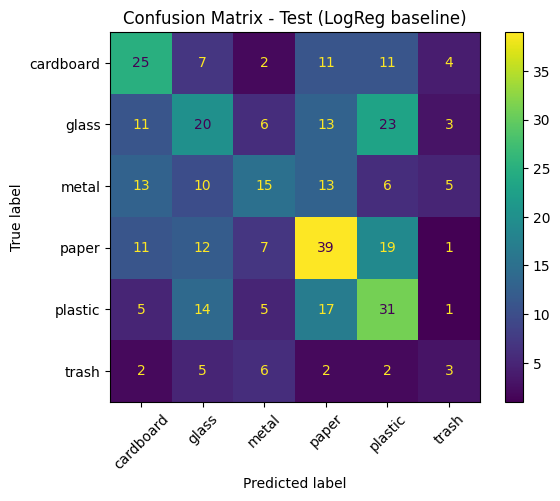

In [10]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - Test (LogReg baseline)")
plt.show()


## Interpretation of the Logistic Regression baseline

In this notebook we evaluated a Logistic Regression model as a baseline for the image classification task.
Each image was resized and flattened into a high-dimensional feature vector, and the model was trained
using a softmax multi-class formulation.

The achieved accuracy on the validation and test sets is approximately **35%**, which is significantly
higher than random guessing (≈16.7% for 6 classes), but still far from satisfactory for a real image
classification task.

From the classification report and the confusion matrix, several patterns emerge:

- Classes such as **paper**, **cardboard**, and **plastic** achieve relatively higher performance.
  These materials tend to have more homogeneous textures and color distributions, which can be partially
  captured by linear combinations of pixel intensities.
- Classes such as **glass**, **metal**, and especially **trash** are frequently confused with other classes.
  This is expected, as these materials often exhibit reflections, transparency, or heterogeneous visual
  characteristics that cannot be effectively modeled by a linear classifier.

The confusion matrix highlights systematic confusions between visually similar materials
(e.g. glass vs plastic, metal vs cardboard), confirming that the model relies only on raw pixel-level
information and ignores spatial structure.

Overall, this baseline demonstrates the limitations of linear models applied directly to image pixels.
The results strongly motivate the use of convolutional neural networks, which are able to exploit local
spatial patterns (edges, textures, shapes) that are crucial for image understanding.


Although the original images are available in RGB and higher resolution, a strong downsampling and grayscale conversion were deliberately applied for the logistic regression baseline. Since logistic regression is a linear model operating on flattened inputs, increasing spatial resolution or color channels would drastically increase dimensionality without enabling the model to exploit spatial or semantic structure, leading to overfitting and limited performance gains. This simplified representation provides a stable and meaningful baseline for comparison with more expressive models.